# Assignment module 2: Develop an xGBoost model for prediction of bus delays

In this assignment I will create a xGBoost model to predict the arrival delays of busses at the Linnégatan on line 1 in Stockholm. The dataset used consists of all arrivals at this stop during may 2022.

### Package import

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb

### Load and prepare the data

In [2]:
url = 'https://raw.githubusercontent.com/zhenliangma/Applied-AI-in-Transportation/master/Exercise_2_regression_model/Exercise2BusData.csv'
df = pd.read_csv(url)
# df = pd.read_csv('Exercise2BusData.csv')

df.head(10)

,Arrival_time,Stop_id,Bus_id,Line_id,Arrival_delay,Dwell_time,Scheduled_travel_time,Upstream_stop_delay,Recurrent_delay
0,01/05/2022 07:03,10033,41355,1,-23,0,39,-4,28.641509
1,01/05/2022 07:21,10033,41356,1,168,0,39,181,27.880597
2,01/05/2022 07:37,10033,44400,1,231,0,39,244,27.852941
3,01/05/2022 07:50,10033,44399,1,150,17,39,143,27.826087
4,01/05/2022 19:29,10033,44060,1,965,35,51,947,42.029412
5,01/05/2022 19:58,10033,41351,1,33,19,46,30,38.970588
6,01/05/2022 20:14,10033,44399,1,75,26,46,63,38.840580
7,01/05/2022 20:28,10033,41356,1,58,15,46,52,34.059701
8,01/05/2022 20:57,10033,44060,1,904,35,46,888,34.102941
9,01/05/2022 21:00,10033,41357,1,141,12,46,140,34.000000


In [3]:
df.shape

(2179, 9)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2179 entries, 0 to 2178
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Arrival_time           2179 non-null   object 
 1   Stop_id                2179 non-null   int64  
 2   Bus_id                 2179 non-null   int64  
 3   Line_id                2179 non-null   int64  
 4   Arrival_delay          2179 non-null   int64  
 5   Dwell_time             2179 non-null   int64  
 6   Scheduled_travel_time  2179 non-null   int64  
 7   Upstream_stop_delay    2179 non-null   int64  
 8   Recurrent_delay        2179 non-null   float64
dtypes: float64(1), int64(7), object(1)
memory usage: 153.3+ KB


The previous code cells show the first 10 lines of the dataset and some information about the columns in the dataset. In the dataset are included the arrival times, stop ID, bus ID, line ID, arrival delay, dwell time, scheduled travel time, upstream stop delay and the recurrent delay. In total the dataset contains 2179 cases and none of the cases contains empty cells in the data set.  

In [5]:
#df = df.iloc[:1000]

The previous line can be used to create a new dataset with a smaller amount of cases in order to limit the computational effort of training the model. It picks the first 1000 lines from the dataset.

In [6]:
df = df.drop(['Arrival_time','Stop_id','Bus_id','Line_id'], axis=1)

The previous line of code drops the arrival time, stop ID, bus ID and line ID from the data set. The arrival time should be dropped for the predicting purposes of this assignment, because this is not known at the moment the prediction is made in practice. The other 3 columns are not useful for the prediction.

<Axes: xlabel='Arrival_delay', ylabel='Count'>

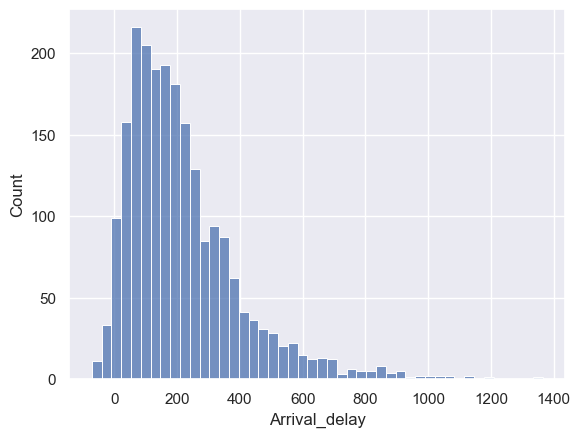

In [7]:
sns.set()
sns.histplot(x=df['Arrival_delay'])

The resulting plot of the previous cell shows that the amount of busses ariving early is limited. Most busses arrive late. Most busses arrive only some minutes late. However, there are also busses in the dataset that arrived more than 10 minutes late.

In [8]:
corr_matrix = df.corr()
corr_matrix['Arrival_delay'].sort_values(ascending=False)

Arrival_delay            1.000000
Upstream_stop_delay      0.993935
Dwell_time               0.218745
Recurrent_delay          0.162692
Scheduled_travel_time    0.100695
Name: Arrival_delay, dtype: float64

The correlation matrix above shows that the arrival delay that we want to predict is mainly correlated with the upstream stop delay.

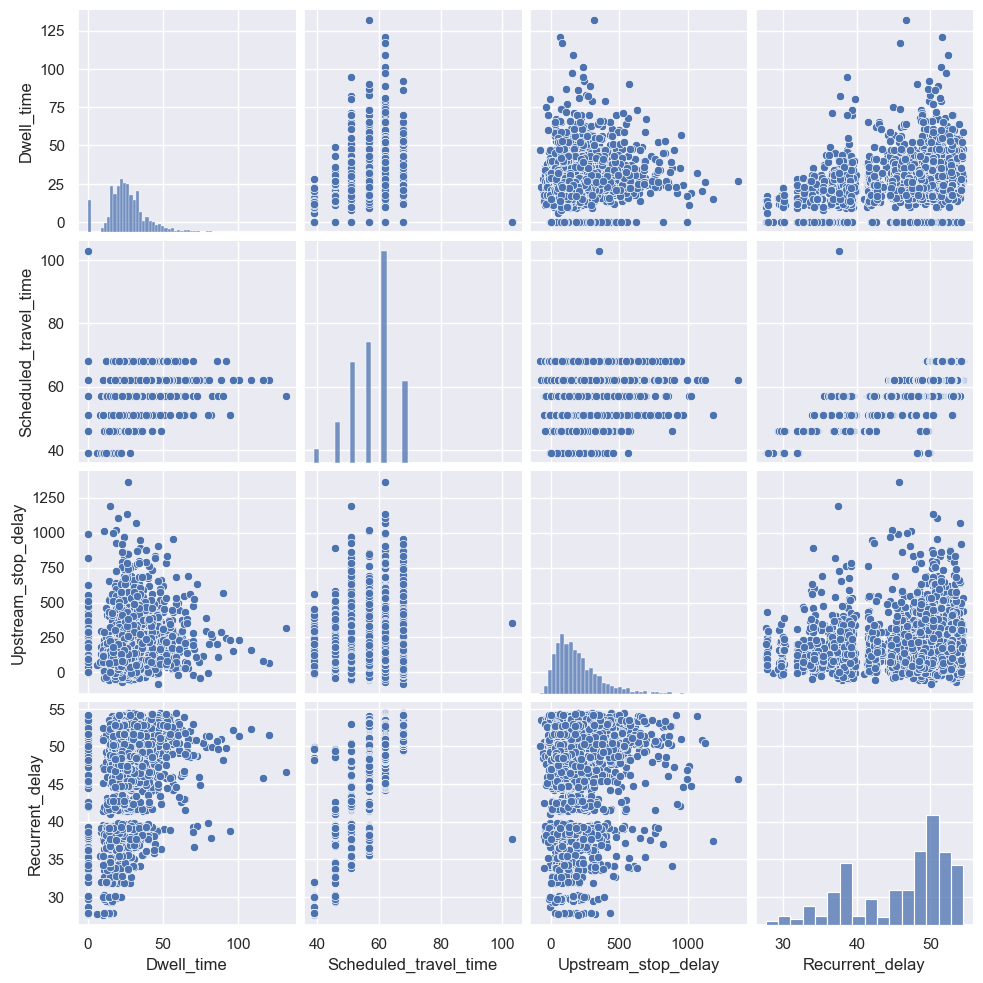

In [9]:
x = df.drop(['Arrival_delay'], axis=1)
y = df['Arrival_delay']

sns.pairplot(x)

From the pairplot above we can get a lot of new information about the dataset in this analysis. For example the longer the scheduled travel time, the longer the dwell time can be (not necessarily must be, but can be). Furthermore, when the scheduled travel time increases, the recurrent delay also increases. 

## Train the xGBoost model

In this assignment I will use a xGBoost model. Specifically a xGBoost model for regression tasks, because the values that need to be predicted are numerical. The data set is split in a training and a test set. Afterwards the xGBoost model is fitted to the data.

In [10]:
model = xgb.XGBRegressor()

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)


param_grid = {
    'n_estimators': [5, 10, 25, 50, 100],
    'max_depth': [5, 10, 25, 50, 100],
    'max_leaves': [5, 10, 25, 50, 100]
}

grid_search = GridSearchCV(model, param_grid, cv=5, verbose=2)

grid_search.fit(x_train, y_train)
#y_pred = model.predict(x_test)

# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

Fitting 5 folds for each of 125 candidates, totalling 625 fits
[CV] END ..........max_depth=5, max_leaves=5, n_estimators=5; total time=   0.0s
[CV] END ..........max_depth=5, max_leaves=5, n_estimators=5; total time=   0.0s
[CV] END ..........max_depth=5, max_leaves=5, n_estimators=5; total time=   0.0s
[CV] END ..........max_depth=5, max_leaves=5, n_estimators=5; total time=   0.0s
[CV] END ..........max_depth=5, max_leaves=5, n_estimators=5; total time=   0.0s
[CV] END .........max_depth=5, max_leaves=5, n_estimators=10; total time=   0.0s
[CV] END .........max_depth=5, max_leaves=5, n_estimators=10; total time=   0.0s
[CV] END .........max_depth=5, max_leaves=5, n_estimators=10; total time=   0.0s
[CV] END .........max_depth=5, max_leaves=5, n_estimators=10; total time=   0.0s
[CV] END .........max_depth=5, max_leaves=5, n_estimators=10; total time=   0.0s
[CV] END .........max_depth=5, max_leaves=5, n_estimators=25; total time=   0.0s
[CV] END .........max_depth=5, max_leaves=5, n

[CV] END .......max_depth=5, max_leaves=100, n_estimators=10; total time=   0.0s
[CV] END .......max_depth=5, max_leaves=100, n_estimators=10; total time=   0.0s
[CV] END .......max_depth=5, max_leaves=100, n_estimators=10; total time=   0.0s
[CV] END .......max_depth=5, max_leaves=100, n_estimators=25; total time=   0.0s
[CV] END .......max_depth=5, max_leaves=100, n_estimators=25; total time=   0.0s
[CV] END .......max_depth=5, max_leaves=100, n_estimators=25; total time=   0.1s
[CV] END .......max_depth=5, max_leaves=100, n_estimators=25; total time=   0.0s
[CV] END .......max_depth=5, max_leaves=100, n_estimators=25; total time=   0.0s
[CV] END .......max_depth=5, max_leaves=100, n_estimators=50; total time=   0.0s
[CV] END .......max_depth=5, max_leaves=100, n_estimators=50; total time=   0.1s
[CV] END .......max_depth=5, max_leaves=100, n_estimators=50; total time=   0.0s
[CV] END .......max_depth=5, max_leaves=100, n_estimators=50; total time=   0.1s
[CV] END .......max_depth=5,

[CV] END .......max_depth=10, max_leaves=50, n_estimators=25; total time=   0.1s
[CV] END .......max_depth=10, max_leaves=50, n_estimators=25; total time=   0.1s
[CV] END .......max_depth=10, max_leaves=50, n_estimators=25; total time=   0.1s
[CV] END .......max_depth=10, max_leaves=50, n_estimators=25; total time=   0.1s
[CV] END .......max_depth=10, max_leaves=50, n_estimators=25; total time=   0.0s
[CV] END .......max_depth=10, max_leaves=50, n_estimators=50; total time=   0.2s
[CV] END .......max_depth=10, max_leaves=50, n_estimators=50; total time=   0.3s
[CV] END .......max_depth=10, max_leaves=50, n_estimators=50; total time=   0.3s
[CV] END .......max_depth=10, max_leaves=50, n_estimators=50; total time=   0.3s
[CV] END .......max_depth=10, max_leaves=50, n_estimators=50; total time=   0.2s
[CV] END ......max_depth=10, max_leaves=50, n_estimators=100; total time=   0.7s
[CV] END ......max_depth=10, max_leaves=50, n_estimators=100; total time=   0.6s
[CV] END ......max_depth=10,

[CV] END .......max_depth=25, max_leaves=25, n_estimators=25; total time=   0.3s
[CV] END .......max_depth=25, max_leaves=25, n_estimators=25; total time=   0.3s
[CV] END .......max_depth=25, max_leaves=25, n_estimators=25; total time=   0.3s
[CV] END .......max_depth=25, max_leaves=25, n_estimators=50; total time=   0.8s
[CV] END .......max_depth=25, max_leaves=25, n_estimators=50; total time=   0.8s
[CV] END .......max_depth=25, max_leaves=25, n_estimators=50; total time=   0.9s
[CV] END .......max_depth=25, max_leaves=25, n_estimators=50; total time=   0.8s
[CV] END .......max_depth=25, max_leaves=25, n_estimators=50; total time=   0.8s
[CV] END ......max_depth=25, max_leaves=25, n_estimators=100; total time=   1.1s
[CV] END ......max_depth=25, max_leaves=25, n_estimators=100; total time=   1.1s
[CV] END ......max_depth=25, max_leaves=25, n_estimators=100; total time=   1.1s
[CV] END ......max_depth=25, max_leaves=25, n_estimators=100; total time=   1.1s
[CV] END ......max_depth=25,

[CV] END .......max_depth=50, max_leaves=10, n_estimators=25; total time=   0.3s
[CV] END .......max_depth=50, max_leaves=10, n_estimators=50; total time=   1.0s
[CV] END .......max_depth=50, max_leaves=10, n_estimators=50; total time=   1.0s
[CV] END .......max_depth=50, max_leaves=10, n_estimators=50; total time=   1.0s
[CV] END .......max_depth=50, max_leaves=10, n_estimators=50; total time=   1.0s
[CV] END .......max_depth=50, max_leaves=10, n_estimators=50; total time=   0.9s
[CV] END ......max_depth=50, max_leaves=10, n_estimators=100; total time=   1.3s
[CV] END ......max_depth=50, max_leaves=10, n_estimators=100; total time=   1.3s
[CV] END ......max_depth=50, max_leaves=10, n_estimators=100; total time=   1.3s
[CV] END ......max_depth=50, max_leaves=10, n_estimators=100; total time=   1.3s
[CV] END ......max_depth=50, max_leaves=10, n_estimators=100; total time=   1.2s
[CV] END ........max_depth=50, max_leaves=25, n_estimators=5; total time=   0.0s
[CV] END ........max_depth=5

[CV] END .......max_depth=100, max_leaves=5, n_estimators=50; total time=   1.2s
[CV] END .......max_depth=100, max_leaves=5, n_estimators=50; total time=   1.0s
[CV] END .......max_depth=100, max_leaves=5, n_estimators=50; total time=   1.1s
[CV] END .......max_depth=100, max_leaves=5, n_estimators=50; total time=   1.1s
[CV] END ......max_depth=100, max_leaves=5, n_estimators=100; total time=   1.8s
[CV] END ......max_depth=100, max_leaves=5, n_estimators=100; total time=   1.5s
[CV] END ......max_depth=100, max_leaves=5, n_estimators=100; total time=   1.5s
[CV] END ......max_depth=100, max_leaves=5, n_estimators=100; total time=   1.4s
[CV] END ......max_depth=100, max_leaves=5, n_estimators=100; total time=   1.4s
[CV] END .......max_depth=100, max_leaves=10, n_estimators=5; total time=   0.0s
[CV] END .......max_depth=100, max_leaves=10, n_estimators=5; total time=   0.0s
[CV] END .......max_depth=100, max_leaves=10, n_estimators=5; total time=   0.0s
[CV] END .......max_depth=10

[CV] END .....max_depth=100, max_leaves=100, n_estimators=50; total time=   0.9s
[CV] END .....max_depth=100, max_leaves=100, n_estimators=50; total time=   0.9s
[CV] END ....max_depth=100, max_leaves=100, n_estimators=100; total time=   1.3s
[CV] END ....max_depth=100, max_leaves=100, n_estimators=100; total time=   1.2s
[CV] END ....max_depth=100, max_leaves=100, n_estimators=100; total time=   1.3s
[CV] END ....max_depth=100, max_leaves=100, n_estimators=100; total time=   1.3s
[CV] END ....max_depth=100, max_leaves=100, n_estimators=100; total time=   1.3s
Best Parameters: {'max_depth': 5, 'max_leaves': 5, 'n_estimators': 25}


In [11]:
# Create a xGBoost model with the best parameters from the grid search
best_xgboost = xgb.XGBRegressor(n_estimators=best_params['n_estimators'], max_depth=best_params['max_depth'], max_leaves=best_params['max_leaves'])

# Perform cross-validation on the entire dataset
cv_scores = cross_val_score(best_xgboost, x , y, cv=5, verbose=2).mean()
print(cv_scores)

[CV] END .................................................... total time=   0.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
0.9910614398516687


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.4s finished


In [12]:
best_xgboost.fit(x_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=5,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=25, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

## Make predictions

In [13]:
y_pred = best_xgboost.predict(x_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Absolute Error: 11.122929774703236
Mean Squared Error: 229.98980346256053
R-squared: 0.9922873869189788


When we compare the results obtained with the xGBoost model with the results of the regression model created for the tutorial, we see that the regression model performs slightly better.

## visualization of the results

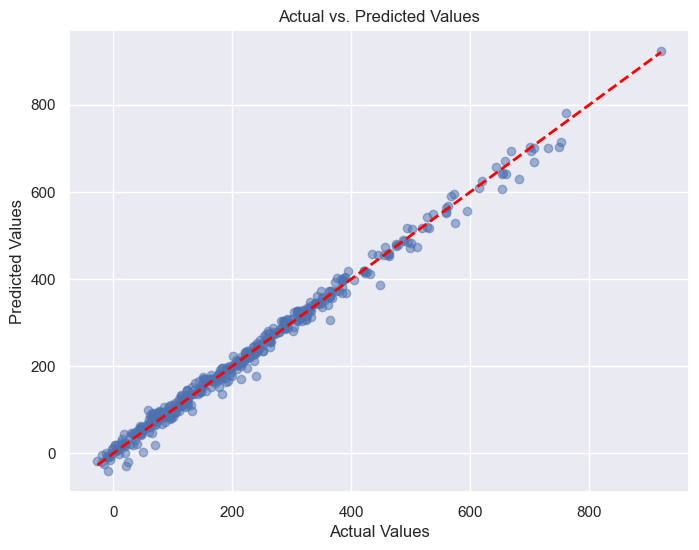

In [14]:
# Create a scatter plot to visualize the relationship
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)  # Plot actual vs. predicted values

# Add labels and title
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values")

# Add a diagonal line for reference (perfect predictions)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', lw=2)

# Show the plot
plt.show()